C:\Users\aniba\OneDrive\Documentos\Anibal\TU Delft\Thesis\BLonD\blond\input_parameters\ring.py:249: UserWarning: WARNING in Ring: The number of turns for the simulation was changed by passing a momentum program.
  warnings.warn("WARNING in Ring: The number of turns for the " +


Matching the bunch... (iteration: 0 and sse: 0.0)
Matching the bunch... (iteration: 0 and sse: 0.0)


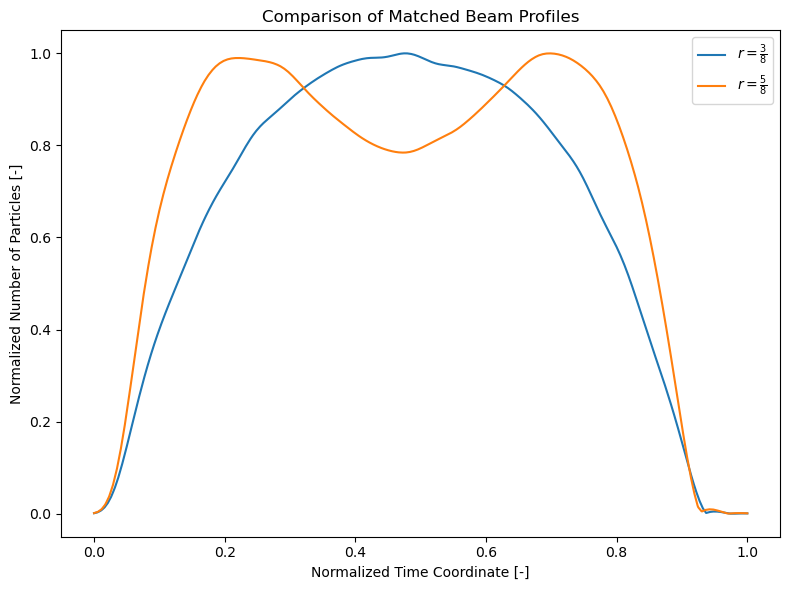

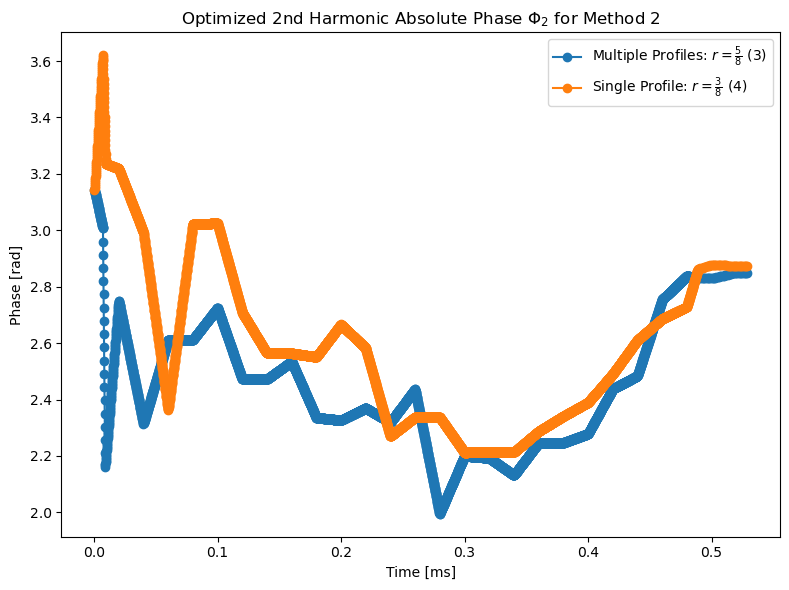

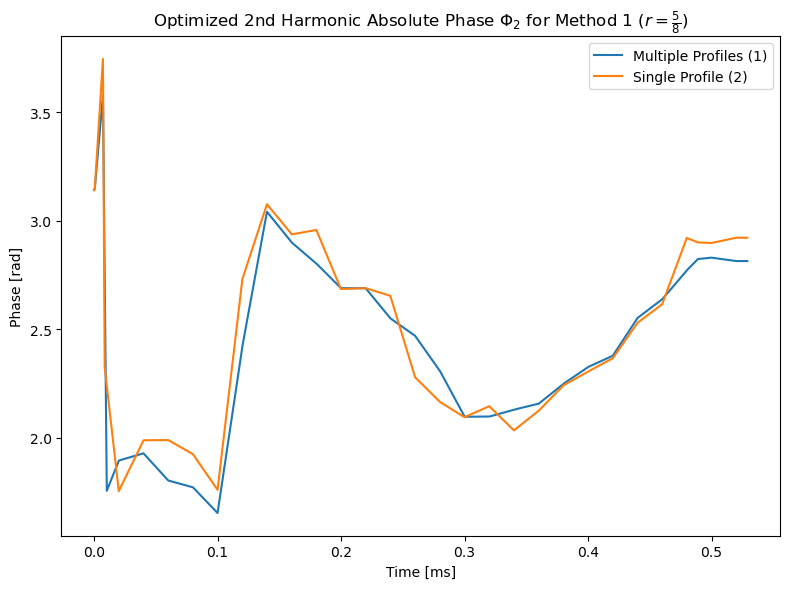

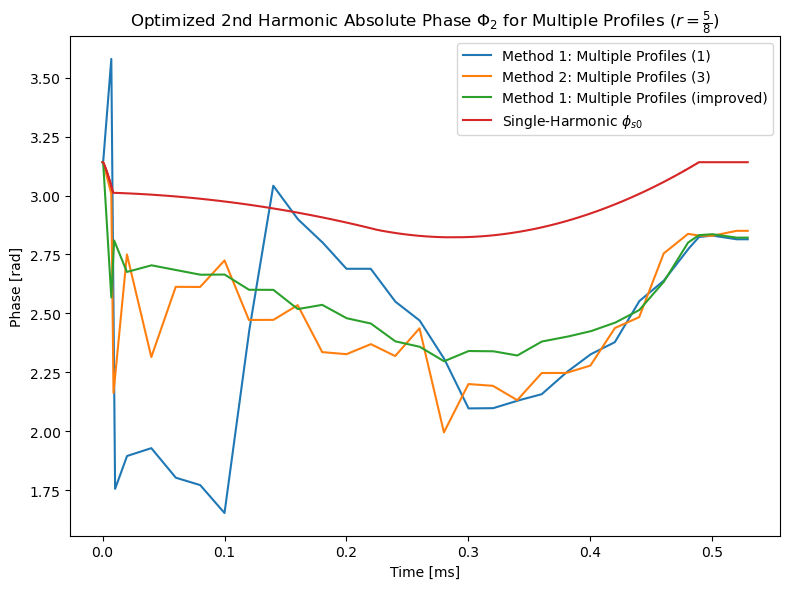

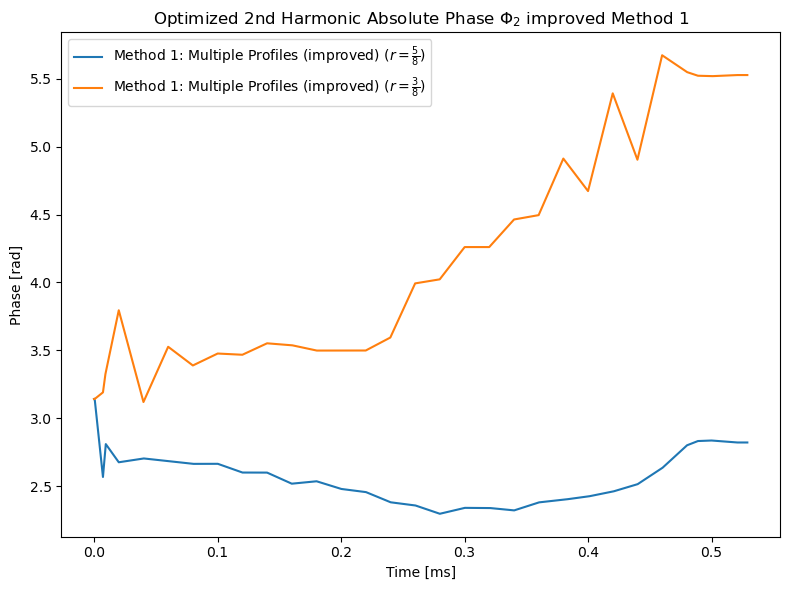

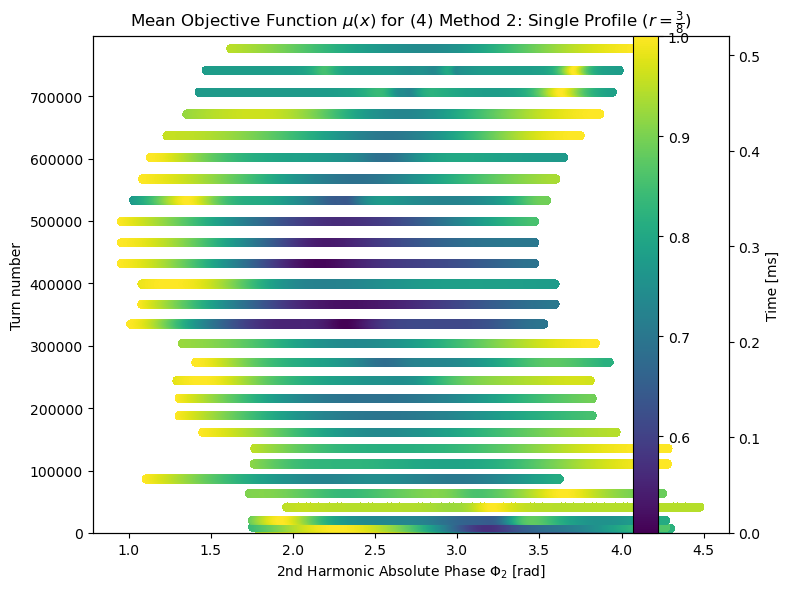

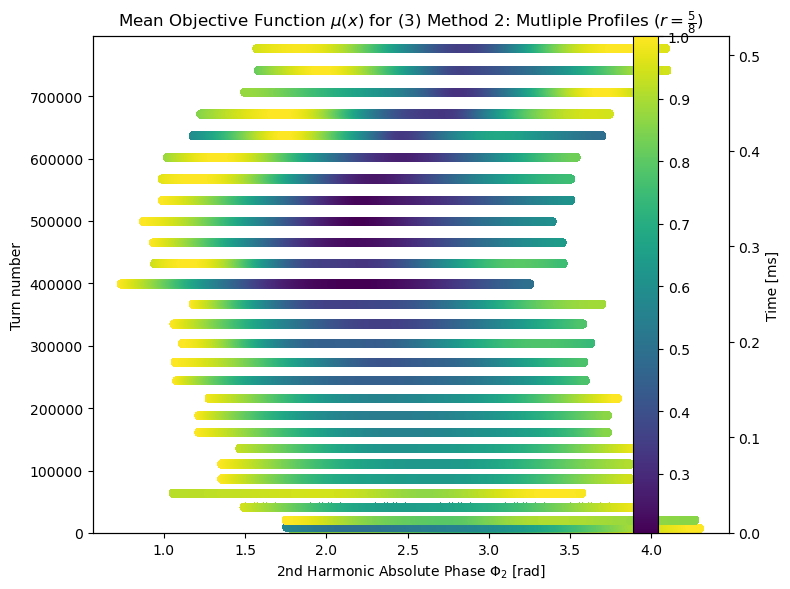

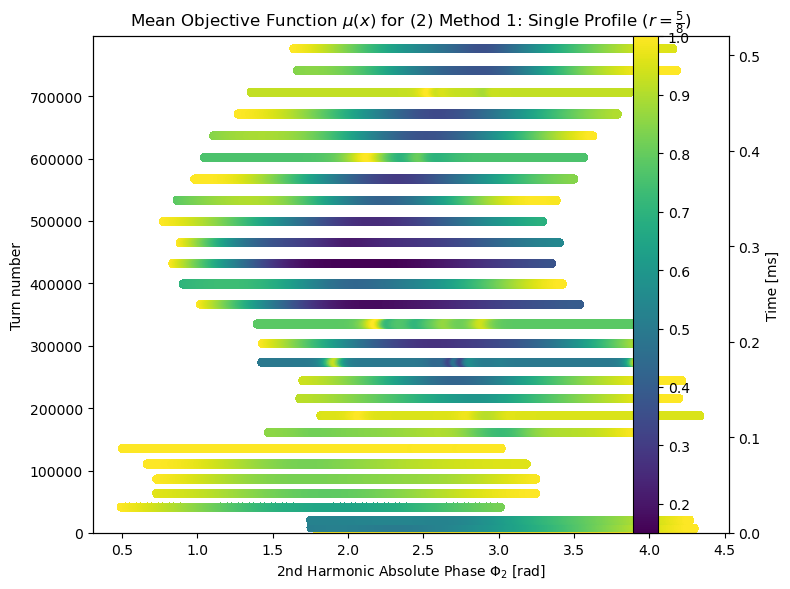

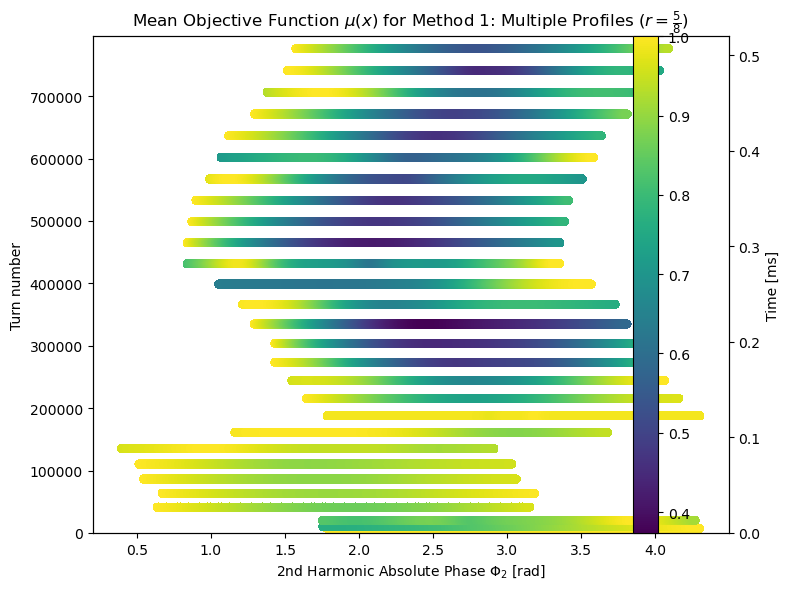

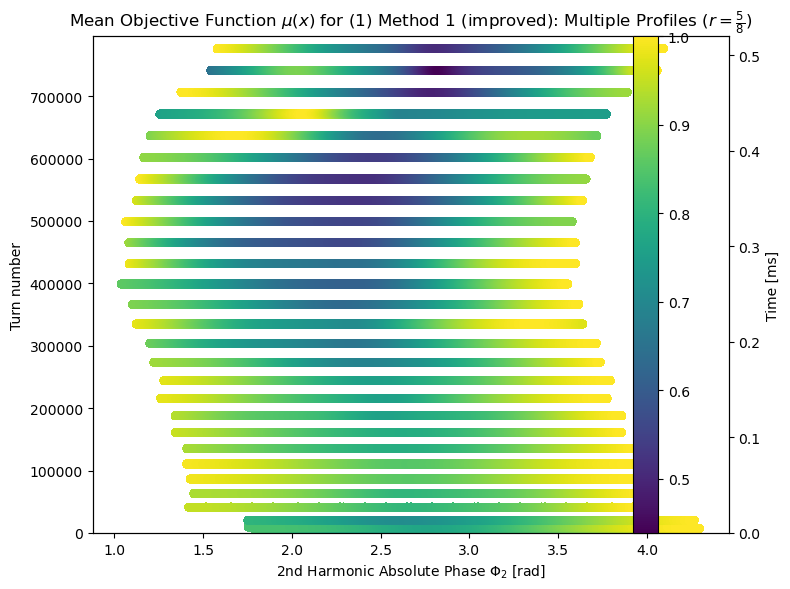

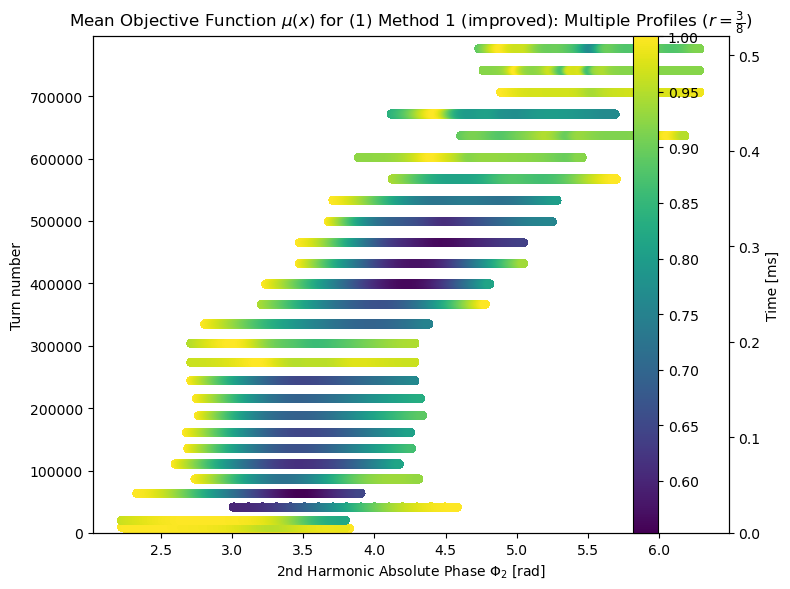

In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import scipy 

import blond.utils.bmath as bm
from blond.beam.beam import Beam, Proton
from blond.beam.distributions import matched_from_distribution_function
from blond.beam.profile import CutOptions, Profile
from blond.input_parameters.rf_parameters import RFStation
from blond.input_parameters.ring import Ring
from blond.trackers.tracker import FullRingAndRF,RingAndRFTracker
#################
from scipy.constants import c, e, m_p
from scipy.signal import butter,lfilter, savgol_filter, find_peaks

from gpu_main_files.utils_opt.func_utils import *
# from scipy.optimize import minimize_scalar
from gpu_main_files.utils_opt.drawnow import ProgramDefOpt, tolSetter





##################


def obj_func_plotter(xs,means,turns, type, times):
    # Plot the the objective function at every sampled turn in a colorplot
    

    fig = plt.figure()

    ax = fig.add_subplot(111)
    

    p = ax.scatter(xs, turns, c=means, cmap='viridis',linewidth = 0, antialiased=False)
    # obs = ax.plot(evals,turns, 'k.')
    # Make another vertical axis for the time (which is equivalent to the turn number)

    ax2 = ax.twinx()

    ax2.set_ylabel('Time [ms]')
    ax2.set_ylim(times[0],times[-1])
    
    unique_turns = np.unique(turns)
    ax.set_ylim(0,unique_turns[-1] + 20000)


    ax.set_xlabel(r'2nd Harmonic Absolute Phase $\Phi_2$ [rad]')
    ax.set_ylabel('Turn number')
    ax.set_title(r'Mean Objective Function $\mu(x)$ for '+ type)

    # Add a colorbar and separate it more from the rest of the figure to make 
    # space for the time axis

    fig.colorbar(p, ax=ax , pad=0.15)
    

# Initialize the reference beam ------------------------------------------------
# Ref beam parameters
n_particles = 2e13
n_macroparticles = 1e6
sigma_dt = 400e-9 /4  # [s]
kin_beam_energy = 160e6  # [eV] # We take the reference beam at 160 MeV

# Machine and RF parameters
radius = 25 # [m]
bend_radius = 8.239 # [m]
gamma_transition = 4.4  # [1]
C = 2 * np.pi * radius  # [m]

# Derived parameters
E_0 = m_p * c**2 / e    # [eV]
tot_beam_energy = E_0 + kin_beam_energy  # [eV]
momentum_compaction = 1 / gamma_transition**2  # [1]
sync_ref_mom = np.sqrt(tot_beam_energy**2 - E_0**2)  # [eV/c]

# RFStation Parameters
n_rf_systems = 2
# harmonic_numbers = 1
harmonic_numbers = [1,2]
voltage_program = [8e3, 5e3]  # [V]
phi_offset = np.pi

#Get the magnetic field and voltage programs for TOF and ISOHRS using pyda
# See if my optimizer still works when accessing the information from the accelerator (even when the v_2 is very low)




# Possibly in the future delete all the reference instances

# DEFINE THE ACTUAL RING + BEAM PROFILE ------------------------------------------------
# Load the momentum program
# Get the current working directory in notebook
home_dir = os.getcwd()
sync_momentum = np.load(home_dir + './input_files/1_4GeVOperational.npy')# in eV/c 

t_arr = sync_momentum[0] #in s
program = sync_momentum[1] * 1e-4 # in Tesla

sync_momentum = program * bend_radius *c #/1e9 # in GeV/c


total_E = np.sqrt(sync_momentum**2 + E_0**2)
kin_energy = total_E - E_0


inj_t = 275  # in s
ext_t = 805  # in s

index_inj = np.where(t_arr <= inj_t)[0][-1]
index_ext = np.where(t_arr >= ext_t)[0][0]

t_arr = t_arr[index_inj:index_ext]
t_arr = (t_arr - t_arr[0])/1e3
sync_momentum = sync_momentum[index_inj:index_ext]
kin_energy = kin_energy[index_inj:index_ext]


t_range = [inj_t, ext_t]
total_sim_t = (ext_t - inj_t)/1000
t_range = [0,t_arr[-1]]
dt = 0.1 # in ms for the timeseries

sync_momentum = (t_arr, sync_momentum)
kin_energy = (t_arr, kin_energy)

# Define the ring and the optimization ranges per optimization run ----------------
ref_ring = Ring(C, momentum_compaction, sync_momentum,
            Proton())

# Initialize the program definer
v1 = voltage_program[0] * np.ones_like(sync_momentum[0])
v2 = voltage_program[1] * np.ones_like(sync_momentum[0])
v2_2 = 3e3 * np.ones_like(sync_momentum[0])
#################


voltages = [(sync_momentum[0], v1), (sync_momentum[0], v2)]

voltages_2 = [(sync_momentum[0], v1), (sync_momentum[0], v2_2)]


fmax=200e6
width_bin = 1/(2*fmax)
# DEFINE REFERENCE RING + BEAM PROFILE --------------------------------------------------


n_slices = np.round(ref_ring.t_rev[0] / width_bin).astype(int)

ref_beam = Beam(ref_ring, n_macroparticles, n_particles)

ref_beam_2 = Beam(ref_ring, n_macroparticles, n_particles)

ref_RF_section = RFStation(ref_ring, harmonic_numbers, [v1[0],v2[0]], [np.pi, np.pi], n_rf_systems)

ref_RF_section_2 = RFStation(ref_ring, harmonic_numbers, [v1[0],v2_2[0]], [np.pi, np.pi], n_rf_systems)

ref_ring_RF_section = RingAndRFTracker(ref_RF_section, ref_beam)

ref_ring_RF_section_2 = RingAndRFTracker(ref_RF_section_2, ref_beam_2)

Full_ref_rrf = FullRingAndRF([ref_ring_RF_section])

Full_ref_rrf_2 = FullRingAndRF([ref_ring_RF_section_2])

# DEFINE REFERENCE SLICES----------------------------------------------------------------
ref_slice_beam = Profile(ref_beam, CutOptions(cut_left=0,
                                         cut_right=ref_ring.t_rev[0], n_slices=n_slices))

ref_slice_beam_2 = Profile(ref_beam_2, CutOptions(cut_left=0,
                                         cut_right=ref_ring.t_rev[0], n_slices=n_slices))

matched_from_distribution_function(ref_beam, Full_ref_rrf, distribution_type='parabolic_line',bunch_length=sigma_dt*4,process_pot_well = False)

matched_from_distribution_function(ref_beam_2, Full_ref_rrf_2, distribution_type='parabolic_line',bunch_length=sigma_dt*4,process_pot_well = False)

ref_slice_beam.track()

ref_slice_beam_2.track()

(x,y) = ref_slice_beam.bin_centers , ref_slice_beam.n_macroparticles

(x2,y2) = ref_slice_beam_2.bin_centers , ref_slice_beam_2.n_macroparticles

# Filter the profile with a low pass butter-filter to remove the high frequency noise

filtered_data = filter_data([ref_slice_beam.bin_centers, ref_slice_beam.n_macroparticles])


filtered_data_2 = filter_data([ref_slice_beam_2.bin_centers, ref_slice_beam_2.n_macroparticles])


interp_ref_beam = comp_prof(filtered_data)

interp_ref_beam_2 = comp_prof(filtered_data_2)

x = np.linspace(0,1,1000)

fig9 , ax9 = plt.subplots(1,1)


ax9.plot(x,interp_ref_beam_2(x),label = r'$r=\frac{3}{8}$')
ax9.plot(x,interp_ref_beam(x),label = r'$r=\frac{5}{8}$')
ax9.set_xlabel(r'Normalized Time Coordinate [-]')
ax9.set_ylabel(r'Normalized Number of Particles [-]')
ax9.set_title('Comparison of Matched Beam Profiles')
ax9.legend()



####################
v1 = ref_RF_section.voltage[0]
stable_phase = -np.arcsin(np.array(ref_ring.delta_E[0]) / v1[:-1]) + np.pi

####################
home_dir = os.getcwd() + '/Sols/'


# Read the flat method 3/8 files 
mean = np.load(home_dir+'./38/mean_obj.npy')
phase_arr = np.load(home_dir+'./38/phase_array.npy')
phase_arr = np.squeeze(phase_arr)
t_arr = np.load(home_dir+'./38/t_arr.npy')
xs = np.load(home_dir+'./38/x_obj.npy')


# Read the flat method 5/8 files
mean2 = np.load(home_dir+'./58/mean_obj.npy')
phase_arr2 = np.load(home_dir+'./58/phase_array.npy')
phase_arr2 = np.squeeze(phase_arr2)
t_arr2 = np.load(home_dir+'./58/t_arr.npy')
turns2 = np.load(home_dir+'./58/turns.npy')
xs2 = np.load(home_dir+'./58/x_obj.npy')

# read the shape method unique 5/8 files 

mean3 = np.load(home_dir+'./shape_58_u/mean_obj.npy')
phase_arr3 = np.load(home_dir+'./shape_58_u/phase_array.npy')
phase_arr3 = np.squeeze(phase_arr3)
t_arr3 = np.load(home_dir+'./shape_58_u/t_arr.npy')
turns3 = np.load(home_dir+'./shape_58_u/turns.npy')
xs3 = np.load(home_dir+'./shape_58_u/x_obj.npy')

# read the shape method multi 5/8 files

mean4 = np.load(home_dir+'./shape_58_full/mean_obj.npy')
phase_arr4 = np.load(home_dir+'./shape_58_full/phase_array.npy')
phase_arr4 = np.squeeze(phase_arr4)
t_arr4 = np.load(home_dir+'./shape_58_full/t_arr.npy')
turns4 = np.load(home_dir+'./shape_58_full/turns.npy')
xs4 = np.load(home_dir+'./shape_58_full/x_obj.npy')

# read the improved shape method 5/8 files

mean5 = np.load(home_dir+'./shape_full_58_cumsum/mean_obj.npy')
phase_arr5 = np.load(home_dir+'./shape_full_58_cumsum/phase_array.npy')
phase_arr5 = np.squeeze(phase_arr5)
t_arr5 = np.load(home_dir+'./shape_full_58_cumsum/t_arr.npy')
turns5 = np.load(home_dir+'./shape_full_58_cumsum/turns.npy')
xs5 = np.load(home_dir+'./shape_full_58_cumsum/x_obj.npy')

# read the improved shape method 3/8 files

mean6 = np.load(home_dir+'./shape_full_38_cumsum/mean_obj.npy')
phase_arr6 = np.load(home_dir+'./shape_full_38_cumsum/phase_array.npy')
phase_arr6 = np.squeeze(phase_arr6)
t_arr6 = np.load(home_dir+'./shape_full_38_cumsum/t_arr.npy')
turns6 = np.load(home_dir+'./shape_full_38_cumsum/turns.npy')
xs6 = np.load(home_dir+'./shape_full_38_cumsum/x_obj.npy')
percent_alives6 = np.load(home_dir+'./shape_full_38_cumsum/percent_alives.npy')


fig , ax = plt.subplots(1,1)

ax.plot(phase_arr2[0],phase_arr2[1], '-o', label = r'Multiple Profiles: $r=\frac{5}{8}$ (3)')
ax.plot(phase_arr[0],phase_arr[1], '-o',label = r'Single Profile: $r=\frac{3}{8}$ (4)')
# Now overlay the error bounds for 2 sigma 

ax.set_xlabel('Time [ms]')
ax.set_ylabel('Phase [rad]')
ax.set_title(r'Optimized 2nd Harmonic Absolute Phase $\Phi_2$ for Method 2')
ax.legend()


fig3 , ax3 = plt.subplots(1,1)

ax3.plot(phase_arr4[0],phase_arr4[1], label = r'Multiple Profiles (1)')
ax3.plot(phase_arr3[0],phase_arr3[1], label = r'Single Profile (2)')
ax3.set_xlabel('Time [ms]')
ax3.set_ylabel('Phase [rad]')
ax3.set_title(r'Optimized 2nd Harmonic Absolute Phase $\Phi_2$ for Method 1 ($r=\frac{5}{8}$)')
ax3.legend()


fig2 , ax2 = plt.subplots(1,1)

ax2.plot(phase_arr4[0],phase_arr4[1], label = r'Method 1: Multiple Profiles (1)')
ax2.plot(phase_arr2[0],phase_arr2[1], label = r'Method 2: Multiple Profiles (3)')
ax2.plot(phase_arr5[0],phase_arr5[1], label = r'Method 1: Multiple Profiles (improved)')
ax2.plot(ref_ring.cycle_time[:-1],stable_phase, label=r'Single-Harmonic $\phi_{s0}$')
ax2.set_xlabel('Time [ms]')
ax2.set_ylabel('Phase [rad]')
ax2.set_title(r'Optimized 2nd Harmonic Absolute Phase $\Phi_2$ for Multiple Profiles ($r=\frac{5}{8}$)')
ax2.legend()

fig11, ax11 = plt.subplots(1,1)
ax11.plot(phase_arr6[0],phase_arr6[1], label = r'Multiple Profiles (improved) $(r=\frac{3}{8}$)')
ax11.plot(phase_arr5[0],phase_arr5[1], label = r'Multiple Profiles (improved) $(r=\frac{5}{8}$)')
ax11.plot(ref_ring.cycle_time[:-1],stable_phase, label=r'Single-Harmonic $\phi_{s0}$')
ax11.set_xlabel('Time [ms]')
ax11.set_ylabel('Phase [rad]')
ax11.set_title(r'Optimized 2nd Harmonic Absolute Phase $\Phi_2$ for (1) Method 1: Multiple Profiles')
ax11.legend()

fig10 , ax10 = plt.subplots(1,1)
ax10.plot(phase_arr5[0],phase_arr5[1], label = r'Method 1: Multiple Profiles (improved) $(r=\frac{5}{8}$)')
ax10.plot(phase_arr6[0],phase_arr6[1], label = r'Method 1: Multiple Profiles (improved) $(r=\frac{3}{8}$)')
ax10.set_xlabel('Time [ms]')
ax10.set_ylabel('Phase [rad]')
ax10.set_title(r'Optimized 2nd Harmonic Absolute Phase $\Phi_2$ improved Method 1')
ax10.legend()

# For each of the mean objective timeseries, normalize the mean function by the max of the mean 
# at that specific turn

means = [ mean, mean2, mean3, mean4,mean5, mean6]
xs_s = [xs, xs2, xs3, xs4, xs5 , xs6]
turns_s = [turns2, turns2, turns3, turns4, turns5 , turns6]
times = [t_arr2, t_arr2, t_arr3, t_arr4, t_arr5, t_arr6]
types = [r'(4) Method 2: Single Profile ($r=\frac{3}{8}$)', r'(3) Method 2: Mutliple Profiles ($r=\frac{5}{8}) $', r'(2) Method 1: Single Profile ($r=\frac{5}{8}$)', r'Method 1: Multiple Profiles ($r=\frac{5}{8}$)', r'(1) Method 1 (improved): Multiple Profiles ($r=\frac{5}{8}$)', r'(1) Method 1 (improved): Multiple Profiles ($r=\frac{3}{8}$)']
for j,m in enumerate(means):
    for i in range(len(m)):
        m[i, :] = m[i,:]/np.max(m[i,:])

    obj_func_plotter(xs_s[j],m,turns_s[j], types[j], times[j])





